### 一.基本原理

该部分参考了[《谱聚类》-刘建平](https://www.cnblogs.com/pinard/p/6221564.html#!comments)，本节会使用矩阵的特征分解，如果对相关概念模糊，可以先看看19章的PCA和LDA以及MDS，谱聚类将每个样本看作空间中的一个点，点与点之间的距离越近则权重越大，而谱聚类同样离不开“同类相近，异类相斥”的核心思想，所以需要量化“同类”的权重，使其尽可能的大，量化“异类”的权重，是其尽可能的小，所以谱聚类的核心内容两个：  

（1）如何表示点与点之间的相似度权重，这里通常可以使用RBF函数，对于任意两点$x_i,x_j$，它们之间的权重可以表示为$w_{ij}=exp\left(-\frac{\left|\left|x_i-x_j\right|\right|_2^2}{2\sigma^2}\right)$  

（2）如何对同类以及异类进行量化：   

> （2.1）同类的权重可以简单由该类包含的样本来决定，对于类别样本点id的集合$A$，定义为$|A|:=A的大小$；   

>（2.2）异类之间的权重可以定义为，$A$集合与$B$任意两点之间的权重和$W(A,B)=\sum_{i\in A,j\in B}w_{ij}$

离我们的优化目标还差一步了，那就是只需要一个单目标来表示同类权重尽可能大，异类权重尽可能小，将其相除即可，即最终的目标函数为：   

$$
    L(A_1,A_2,...,A_k)=\sum_{i=1}^k\frac{W(A_i,\bar{A_i})}{|A_i|}
$$  

其中，$k$为类别数，即我们定义的超参数，$\bar{A_i}$为$A_i$的补集，显然聚类任务要求$A_1,A_2,...,A_k$之间互斥且完备  

### 二.优化目标推导
我们的优化目标是从$A_1,A_2,...,A_k$的不同组合中选择使$L(A_1,A_2,...,A_k)$最小的，这显然是一个NP-Hard问题，借鉴降维的思想，我们假设这$k$聚类由$k$个指示向量来表示:$h_1,h2,...,h_k$,其中每个向量$h_j$是$n$维向量（$n$是样本量），并令：   

$$
h_{ij}=\left\{\begin{matrix}
0 & i\notin A_j\\ 
\frac{1}{\sqrt{|A_j|}} & i\in A_j
\end{matrix}\right. j=1,2,..,k;i=1,2,...,n
$$  

所以，我们聚类指示向量之间是单位正交化的$h_i^Th_i=1,h_i^Th_j=0$，所以上面的组合问题就转换为了求指示向量的问题，让我们推导一下  

$$
\begin{equation}
\begin{split}
\frac{W(A_i,\bar{A_i})}{|A_i|}&=\frac{1}{2}\left(\frac{W(A_i,\bar{A_i})}{|A_i|}+\frac{W(\bar{A_i},A_i)}{|A_i|}\right)\\
&=\frac{1}{2}(\sum_{m\in A_i,n\notin A_i}\frac{w_{mn}}{|A_i|}+\sum_{m\notin A_i,n\in A_i}\frac{w_{mn}}{|A_i|})\\
&=\frac{1}{2}\sum_{m,n}w_{mn}(h_{mi}-h_{ni})^2\\
&=h_i^TLh_i
\end{split}
\end{equation}
$$  

其中，$L$即是拉普拉斯矩阵，它由两部分构成:   

$$
L=D-W
$$  

这里，$D=diag(d_1,d_2,...,d_n),d_i=\sum_{j=1}^nw_{ij}$，而$W_{ij}=w_{ij}$  

所以，整体的损失函数，可以表示为：  

$$
\begin{equation}
\begin{split}
L(A_1,A_2,...,A_k)&=\sum_{i=1}^k h_i^TLh_i\\
&=tr(H^TLH)\\
s.t.H^TH=I
\end{split}
\end{equation}
$$  

所以，$H\in R^{n\times k}$就是对$L$对特征分解后，由最小的$k$个特征值对应的特征向量组成，当然实际求解出的$H$未必能满足我们的期望：  

$$
h_{ij}=\left\{\begin{matrix}
0 & i\notin A_j\\ 
\frac{1}{\sqrt{|A_j|}} & i\in A_j
\end{matrix}\right. j=1,2,..,k;i=1,2,...,n
$$  

所以，通常还需要对其进行一次聚类，比如K-means

### 三.代码实现

In [1]:
import os
os.chdir('../')
from matplotlib import pyplot as plt
%matplotlib inline
import ml_models
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]

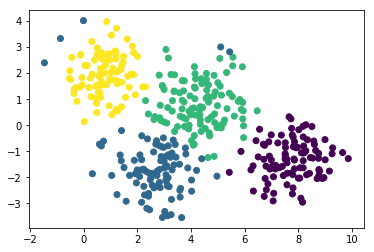

In [2]:
#训练
from ml_models.cluster import Spectral
spectral = Spectral(n_clusters=4)
plt.scatter(X[:, 0], X[:, 1], c=spectral.fit_predict(X))
plt.show()

### 四.讨论

可以发现谱聚类的灵活度很高，里面可以替换的组件很多，给了我们很大的空间，比如（1）相似矩阵的度量，可以采用其他核函数;（2）最终的聚类算法除了采用kmeans也可以尝试其他算法;（3）另外损失函数的定义还有其他方式，比如将$|A_i|$替换为$vol(A_i)$，它的定义为$vol(A_i)=\sum_{j\in A_i}d_j$,这也是谱聚类常用的另外一种损失函数定义，具体推导与上面的过程类似。另外由于谱聚类由相似矩阵推导而来，所以它对于稀疏矩阵比较友好，但是由于谱聚类的pipline结构，可能会由于某一组件的表现较差而影响最终的结果。